In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Feature Processing and Model Training Script

This script processes feature files from multiple folders, trains and evaluates 
various classification models, selects the best model for each folder based on 
F1 score, and generates predictions for test sets.
"""

import os
import time
import logging
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.linear_model import (LogisticRegression, RidgeClassifier, 
                                SGDClassifier, Perceptron, 
                                PassiveAggressiveClassifier)
from sklearn.svm import SVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                        QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                            AdaBoostClassifier, GradientBoostingClassifier,
                            HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from joblib import Parallel, delayed, Memory
import multiprocessing

# Configure logging
logging.basicConfig(
    filename='model_performance.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up memory caching
cache_dir = '.joblib_cache'
os.makedirs(cache_dir, exist_ok=True)
memory = Memory(location=cache_dir, verbose=0)

class FeatureProcessor:
    """Handles loading and processing of feature files."""
    
    def __init__(self, folders):
        """
        Initialize the feature processor.
        
        Args:
            folders (list): List of folder names containing feature files.
        """
        self.folders = folders
        self.label_encoders = {}
        
    def load_data(self, folder, file_name):
        """
        Load data from a CSV file.
        
        Args:
            folder (str): Folder name.
            file_name (str): File name.
            
        Returns:
            DataFrame or None: Loaded data or None if file not found.
        """
        try:
            file_path = os.path.join(folder, file_name)
            df = pd.read_csv(file_path)
            # Store the file path as an attribute for reference
            df.filepath = file_path
            return df
        except FileNotFoundError:
            logging.error(f"File not found: {file_path}")
            return None
        except Exception as e:
            logging.error(f"Error loading {file_path}: {str(e)}")
            return None
    
    def process_features(self, df, is_train=False, is_test=False):
        """
        Process features from a DataFrame.
        
        Args:
            df (DataFrame): Input DataFrame.
            is_train (bool): Whether this is training data.
            is_test (bool): Whether this is test data.
            
        Returns:
            tuple: Features and labels (if not test data).
        """
        if df is None:
            return (None, None) if is_test else (None, None, None)
        
        # Extract ID column - ensure it's correctly identified
        id_col = 'ID' if 'ID' in df.columns else df.columns[0]
        ids = df[id_col].values
        
        # Extract features (assuming they are named f_0 through f_1023 or are columns 1-512)
        feature_cols = [f"f_{i}" for i in range(512)]
        
        # Check if feature columns exist by name
        if all(col in df.columns for col in feature_cols):
            features = df[feature_cols].values
        else:
            # If feature columns don't exist by name, find them by position
            # Determine start and end indices for features
            start_idx = 1  # Assuming ID is the first column
            # For test data, all remaining columns are features
            # For train/dev data, all columns except the last one (label) are features
            end_idx = len(df.columns) if is_test else len(df.columns) - 1
            
            # Validate that we have enough columns for the expected features
            if end_idx - start_idx >= 512:
                features = df.iloc[:, start_idx:start_idx+512].values
            else:
                # Handle the case where there aren't enough columns
                logging.warning(f"Expected 512 features, but found {end_idx - start_idx}. Using all available.")
                features = df.iloc[:, start_idx:end_idx].values
        
        if is_test:
            return ids, features
        
        # Extract label
        if 'label' in df.columns:
            labels = df['label'].values
        else:
            # Assume label is the last column
            labels = df.iloc[:, -1].values
            
        # Encode labels if training data
        if is_train:
            # Extract folder name from file path
            if hasattr(df, 'filepath'):
                folder_name = os.path.basename(os.path.dirname(df.filepath))
            else:
                folder_name = "unknown"
                
            self.label_encoders[folder_name] = LabelEncoder()
            labels = self.label_encoders[folder_name].fit_transform(labels)
        
        return ids, features, labels

class ModelTrainer:
    """Trains and evaluates models on feature data."""
    
    def __init__(self):
        """Initialize the model trainer with a list of classification models."""
        self.models = {
            "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
            "Ridge Classifier": RidgeClassifier(),
            "SGD Classifier": SGDClassifier(n_jobs=-1),
            "Perceptron": Perceptron(),
            "Passive Aggressive": PassiveAggressiveClassifier(),
            "SVM (Linear)": SVC(kernel='linear', probability=True),
            "SVM (RBF)": SVC(kernel='rbf', probability=True),
            "Nu-SVM": NuSVC(probability=True),
            "KNN": KNeighborsClassifier(n_jobs=-1),
            "Decision Tree": DecisionTreeClassifier(),
            "GaussianNB": GaussianNB(),
            "BernoulliNB": BernoulliNB(),
            "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
            "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
            "Random Forest": RandomForestClassifier(n_jobs=-1),
            "Extra Trees": ExtraTreesClassifier(n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(),
            "Gradient Boosting": GradientBoostingClassifier(),
            "HistGradientBoosting": HistGradientBoostingClassifier(),
            "XGBoost": XGBClassifier(eval_metric='mlogloss', n_jobs=-1),
            "LightGBM": LGBMClassifier(n_jobs=-1),
            "CatBoost": CatBoostClassifier(verbose=0, thread_count=-1)
        }
    
    def train_and_evaluate_model(self, model_name, model, X_train, y_train, X_dev, y_dev):
        """
        Train a model and evaluate it on development data.
        
        Args:
            model_name (str): Name of the model.
            model: Model instance.
            X_train: Training features.
            y_train: Training labels.
            X_dev: Development features.
            y_dev: Development labels.
            
        Returns:
            tuple: Model name, fitted model, and F1 score.
        """
        try:
            # Clone the model to avoid modifying the original
            model_copy = model
            
            # Fit the model
            model_copy.fit(X_train, y_train)
            
            # Predict on development data
            y_pred = model_copy.predict(X_dev)
            
            # Calculate F1 score (macro-averaged for multi-class)
            f1 = f1_score(y_dev, y_pred, average='macro')
            
            return model_name, model_copy, f1
        except Exception as e:
            logging.error(f"Error training {model_name}: {str(e)}")
            return model_name, None, -1
    
    def train_and_evaluate_all_models(self, X_train, y_train, X_dev, y_dev):
        """
        Train and evaluate all models using parallel processing.
        
        Args:
            X_train: Training features.
            y_train: Training labels.
            X_dev: Development features.
            y_dev: Development labels.
            
        Returns:
            list: Results for all models.
        """
        # Determine the number of processes to use (leave 1 core for system)
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        
        results = []
        for name, model in self.models.items():
            logging.info(f"Training model: {name}")
            result = self.train_and_evaluate_model(name, model, X_train, y_train, X_dev, y_dev)
            results.append(result)
            
        # Sort results by F1 score (descending)
        results.sort(key=lambda x: x[2], reverse=True)
        
        return results

class TestPredictor:
    """Generates predictions on test data using trained models."""
    
    def predict_and_save(self, model, ids, X_test, output_file, label_encoder=None):
        """
        Generate predictions and save them to a CSV file.
        
        Args:
            model: Trained model.
            ids: Test data IDs.
            X_test: Test features.
            output_file (str): Output file path.
            label_encoder: Label encoder for transforming predictions back to original labels.
            
        Returns:
            bool: True if successful, False otherwise.
        """
        try:
            # Generate predictions
            y_pred = model.predict(X_test)
            
            # Transform predictions back to original labels if label encoder is provided
            if label_encoder is not None:
                y_pred = label_encoder.inverse_transform(y_pred)
            
            # Create a DataFrame with IDs and predictions
            results = pd.DataFrame({
                'ID': ids,
                'predicted_label': y_pred
            })
            
            # Create output directory if it doesn't exist
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            
            # Save to CSV
            results.to_csv(output_file, index=False)
            
            logging.info(f"Predictions saved to {output_file}")
            return True
        except Exception as e:
            logging.error(f"Error generating predictions: {str(e)}")
            return False

def main():
    """Main function to orchestrate the entire process."""
    
    # Start timing
    start_time = time.time()
    
    # Define folders
    folders = [
        'google bert',
        'indic bert',
        'seanbenhur bert',
        'xlm roberta base',
        'xlm roberta large'
    ]
    
    # Initialize components
    processor = FeatureProcessor(folders)
    trainer = ModelTrainer()
    predictor = TestPredictor()
    
    # Process each folder
    for folder in folders:
        logging.info(f"Processing folder: {folder}")
        print(f"Processing folder: {folder}")
        
        # Load training data
        train_df = processor.load_data(folder, 'train_512_features')
        if train_df is None:
            logging.error(f"Skipping {folder} due to missing training data")
            print(f"Skipping {folder} due to missing training data")
            continue
            
        ids_train, X_train, y_train = processor.process_features(train_df, is_train=True)
        
        if X_train is None or y_train is None:
            logging.error(f"Skipping {folder} due to issues with training data")
            print(f"Skipping {folder} due to issues with training data")
            continue
        
        # Load development data
        dev_df = processor.load_data(folder, 'dev_512_features')
        if dev_df is None:
            logging.error(f"Skipping {folder} due to missing development data")
            print(f"Skipping {folder} due to missing development data")
            continue
            
        ids_dev, X_dev, y_dev = processor.process_features(dev_df)
        
        if X_dev is None or y_dev is None:
            logging.error(f"Skipping {folder} due to issues with development data")
            print(f"Skipping {folder} due to issues with development data")
            continue
        
        # Train and evaluate all models
        logging.info(f"Training and evaluating models for {folder}")
        print(f"Training and evaluating models for {folder}")
        results = trainer.train_and_evaluate_all_models(X_train, y_train, X_dev, y_dev)
        
        # Log model rankings
        logging.info(f"Model rankings for {folder}:")
        print(f"Model rankings for {folder}:")
        for name, model, f1 in results:
            if model is not None:
                logging.info(f"  {name}: F1 = {f1:.4f}")
                print(f"  {name}: F1 = {f1:.4f}")
        
        # Select best model
        if results and results[0][1] is not None:
            best_name, best_model, best_f1 = results[0]
            logging.info(f"Best model for {folder}: {best_name} (F1 = {best_f1:.4f})")
            print(f"Best model for {folder}: {best_name} (F1 = {best_f1:.4f})")
            
            # Load test data
            test_df = processor.load_data(folder, 'test_512_features')
            if test_df is None:
                logging.error(f"Skipping prediction for {folder} due to missing test data")
                print(f"Skipping prediction for {folder} due to missing test data")
                continue
                
            ids_test, X_test = processor.process_features(test_df, is_test=True)
            
            if X_test is not None:
                # Generate predictions using the best model
                output_file = os.path.join(folder, 'test_predictions.csv')
                success = predictor.predict_and_save(
                    best_model, 
                    ids_test, 
                    X_test, 
                    output_file, 
                    processor.label_encoders.get(folder)
                )
                if success:
                    print(f"Predictions saved to {output_file}")
            else:
                logging.error(f"Unable to process test data for {folder}")
                print(f"Unable to process test data for {folder}")
        else:
            logging.error(f"No successful models for {folder}")
            print(f"No successful models for {folder}")
    
    # Calculate total execution time
    end_time = time.time()
    execution_time = end_time - start_time
    logging.info(f"Total execution time: {execution_time:.2f} seconds")
    print(f"Total execution time: {execution_time:.2f} seconds")

if __name__ == "__main__":
    main()

Processing folder: google bert
Training and evaluating models for google bert
[LightGBM] [Info] Number of positive: 2133, number of negative: 3438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 5571, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382876 -> initscore=-0.477360
[LightGBM] [Info] Start training from score -0.477360
Model rankings for google bert:
  Random Forest: F1 = 0.8031
  Decision Tree: F1 = 0.8030
  HistGradientBoosting: F1 = 0.8004
  Extra Trees: F1 = 0.8001
  XGBoost: F1 = 0.7958
  Linear Discriminant Analysis: F1 = 0.7952
  AdaBoost: F1 = 0.7946
  LightGBM: F1 = 0.7931
  KNN: F1 = 0.7915
  CatBoost: F1 = 0.7895
  SGD Classifier: F1 = 0.7894
  SVM (Linear): F1 = 0.7868
  Gradient Boosting: F1 = 0.7861
  Perceptron: F1 = 0.7858
  B

Loading prediction files...
Loading predictions from google bert\test_predictions.csv
  Found 1576 predictions
Loading predictions from indic bert\test_predictions.csv
  Found 1576 predictions
Loading predictions from seanbenhur bert\test_predictions.csv
  Found 1576 predictions
Loading predictions from xlm roberta base\test_predictions.csv
  Found 1576 predictions
Loading predictions from xlm roberta large\test_predictions.csv
  Found 1576 predictions
Successfully loaded 5 prediction files
Total unique IDs found: 1576

Organized predictions for 1576 unique IDs

Majority voting completed!
Generated 1576 final predictions

Sample of final predictions:


,ID,predicted_label,confidence,vote_count
0,13,0,0.8,5
1,26,1,1.0,5
2,30,0,1.0,5
3,31,0,1.0,5
4,34,0,1.0,5
5,35,0,1.0,5
6,40,0,1.0,5
7,53,0,1.0,5
8,58,1,0.6,5
9,60,0,1.0,5



Majority voting statistics:
total_samples: 1576
unique_labels: 2
label_distribution:
  0: 1028
  1: 548
avg_confidence: 0.9038071065989848
unanimous_votes: 1082
unanimous_percentage: 68.65482233502537


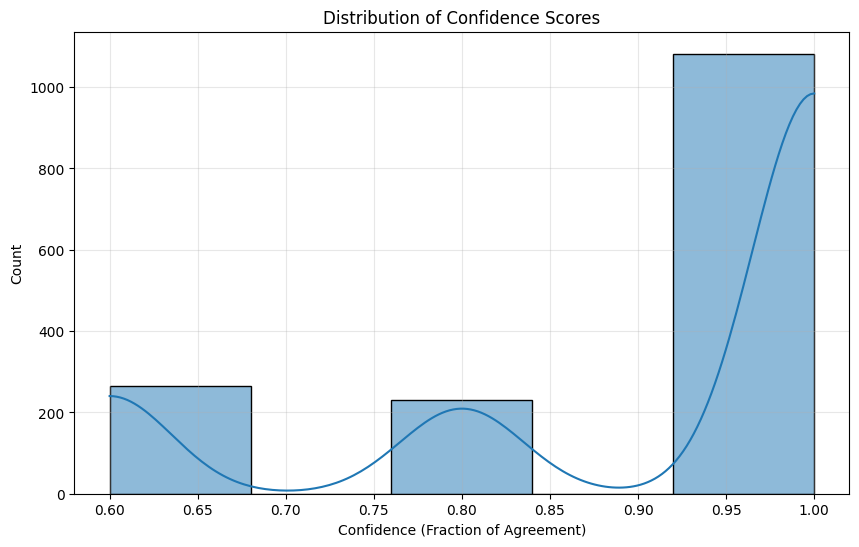

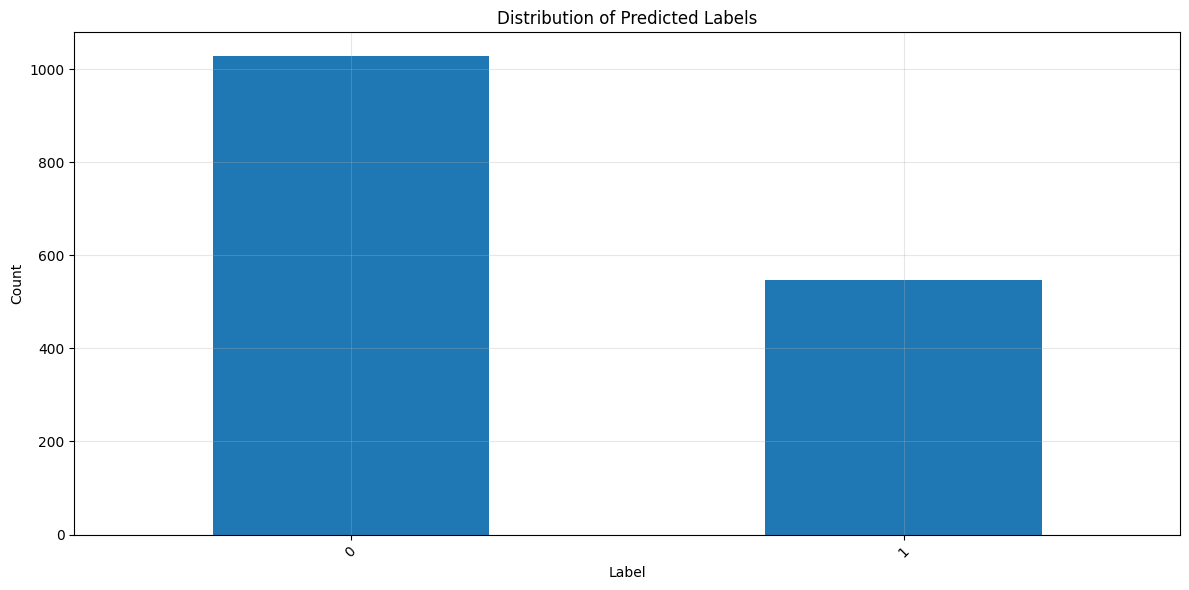


Final predictions saved to final_predictions.csv


In [2]:
# Majority Voting for BERT Model Predictions

import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define folders that contain the test_predictions.csv files
folders = [
    'google bert',
    'indic bert',
    'seanbenhur bert',
    'xlm roberta base',
    'xlm roberta large'
]

print("Loading prediction files...")

# Store prediction dataframes
prediction_files = {}
all_ids = set()

# Load all prediction files
for folder in folders:
    file_path = os.path.join(folder, 'test_predictions.csv')
    
    if os.path.exists(file_path):
        print(f"Loading predictions from {file_path}")
        df = pd.read_csv(file_path)
        
        # Ensure the DataFrame has the expected columns
        if 'ID' in df.columns and 'predicted_label' in df.columns:
            prediction_files[folder] = df
            all_ids.update(df['ID'].tolist())
            print(f"  Found {len(df)} predictions")
        else:
            print(f"  Error: File {file_path} is missing required columns")
    else:
        print(f"  Warning: File not found: {file_path}")

# Check if we have any predictions
if not prediction_files:
    print("Error: No valid prediction files found")
else:
    print(f"Successfully loaded {len(prediction_files)} prediction files")
    print(f"Total unique IDs found: {len(all_ids)}")

# Organize predictions by ID
organized_predictions = {}

for folder, df in prediction_files.items():
    for _, row in df.iterrows():
        id_val = row['ID']
        label = row['predicted_label']
        
        if id_val not in organized_predictions:
            organized_predictions[id_val] = []
        
        organized_predictions[id_val].append(label)

print(f"\nOrganized predictions for {len(organized_predictions)} unique IDs")

# Perform majority voting
final_predictions = []

for id_val, labels in organized_predictions.items():
    # Count the frequency of each label
    label_counts = Counter(labels)
    
    # Get the most common label
    most_common_label, count = label_counts.most_common(1)[0]
    
    # Calculate confidence as fraction of votes
    confidence = count / len(labels)
    
    final_predictions.append({
        'ID': id_val,
        'predicted_label': most_common_label,
        'confidence': confidence,
        'vote_count': len(labels)
    })

# Convert to DataFrame
final_df = pd.DataFrame(final_predictions)

# Sort by ID
final_df = final_df.sort_values('ID').reset_index(drop=True)

print("\nMajority voting completed!")
print(f"Generated {len(final_df)} final predictions")

# Display sample of final predictions
print("\nSample of final predictions:")
display(final_df.head(10))

# Calculate statistics
stats = {
    'total_samples': len(final_df),
    'unique_labels': final_df['predicted_label'].nunique(),
    'label_distribution': final_df['predicted_label'].value_counts().to_dict(),
    'avg_confidence': final_df['confidence'].mean(),
    'unanimous_votes': (final_df['confidence'] == 1.0).sum(),
    'unanimous_percentage': (final_df['confidence'] == 1.0).mean() * 100
}

print("\nMajority voting statistics:")
for key, value in stats.items():
    if key != 'label_distribution':
        print(f"{key}: {value}")
    else:
        print(f"{key}:")
        for label, count in value.items():
            print(f"  {label}: {count}")

# Visualize confidence distribution
plt.figure(figsize=(10, 6))
sns.histplot(final_df['confidence'], bins=len(prediction_files), kde=True)
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence (Fraction of Agreement)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Visualize label distribution
plt.figure(figsize=(12, 6))
final_df['predicted_label'].value_counts().plot(kind='bar')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save final predictions
output_file = 'final_predictions.csv'
final_df.to_csv(output_file, index=False)
print(f"\nFinal predictions saved to {output_file}")

In [3]:
example = pd.read_csv('final_predictions.csv')

In [4]:
example = example.drop('confidence',axis=1)
example = example.drop('vote_count',axis=1)
output_file = 'final_test.csv'
example.to_csv(output_file, index=False)

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Feature Processing and Model Training Script

This script processes feature files from multiple folders, trains the best models
using combined training and development data, generates predictions for test sets,
and creates a final prediction file using majority voting.
"""

import os
import time
import logging
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from collections import Counter

# Configure logging
logging.basicConfig(
    filename='model_performance.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Suppress warnings
warnings.filterwarnings('ignore')

class FeatureProcessor:
    """Handles loading and processing of feature files."""
    
    def __init__(self, folders):
        """
        Initialize the feature processor.
        
        Args:
            folders (list): List of folder names containing feature files.
        """
        self.folders = folders
        self.label_encoders = {}
        
    def load_data(self, folder, file_name):
        """
        Load data from a CSV file.
        
        Args:
            folder (str): Folder name.
            file_name (str): File name.
            
        Returns:
            DataFrame or None: Loaded data or None if file not found.
        """
        try:
            file_path = os.path.join(folder, file_name)
            df = pd.read_csv(file_path)
            # Store the file path as an attribute for reference
            df.filepath = file_path
            return df
        except FileNotFoundError:
            logging.error(f"File not found: {file_path}")
            return None
        except Exception as e:
            logging.error(f"Error loading {file_path}: {str(e)}")
            return None
    
    def process_features(self, df, is_train=False, is_test=False):
        """
        Process features from a DataFrame.
        
        Args:
            df (DataFrame): Input DataFrame.
            is_train (bool): Whether this is training data.
            is_test (bool): Whether this is test data.
            
        Returns:
            tuple: Features and labels (if not test data).
        """
        if df is None:
            return (None, None) if is_test else (None, None, None)
        
        # Extract ID column - ensure it's correctly identified
        id_col = 'ID' if 'ID' in df.columns else df.columns[0]
        ids = df[id_col].values
        
        # Extract features (assuming they are named f_0 through f_511 or are columns 1-512)
        feature_cols = [f"f_{i}" for i in range(512)]
        
        # Check if feature columns exist by name
        if all(col in df.columns for col in feature_cols):
            features = df[feature_cols].values
        else:
            # If feature columns don't exist by name, find them by position
            # Determine start and end indices for features
            start_idx = 1  # Assuming ID is the first column
            # For test data, all remaining columns are features
            # For train/dev data, all columns except the last one (label) are features
            end_idx = len(df.columns) if is_test else len(df.columns) - 1
            
            # Validate that we have enough columns for the expected features
            if end_idx - start_idx >= 512:
                features = df.iloc[:, start_idx:start_idx+512].values
            else:
                # Handle the case where there aren't enough columns
                logging.warning(f"Expected 512 features, but found {end_idx - start_idx}. Using all available.")
                features = df.iloc[:, start_idx:end_idx].values
        
        if is_test:
            return ids, features
        
        # Extract label
        if 'label' in df.columns:
            labels = df['label'].values
        else:
            # Assume label is the last column
            labels = df.iloc[:, -1].values
            
        # Encode labels if training data
        if is_train:
            # Extract folder name from file path
            if hasattr(df, 'filepath'):
                folder_name = os.path.basename(os.path.dirname(df.filepath))
            else:
                folder_name = "unknown"
                
            self.label_encoders[folder_name] = LabelEncoder()
            labels = self.label_encoders[folder_name].fit_transform(labels)
        
        return ids, features, labels

    def combine_datasets(self, train_df, dev_df):
        """
        Combine training and development datasets.
        
        Args:
            train_df (DataFrame): Training dataframe.
            dev_df (DataFrame): Development dataframe.
            
        Returns:
            DataFrame: Combined dataframe.
        """
        if train_df is None or dev_df is None:
            return None
            
        # Make sure we have the filepath attribute
        if hasattr(train_df, 'filepath'):
            combined_df = pd.concat([train_df, dev_df], ignore_index=True)
            combined_df.filepath = train_df.filepath
            return combined_df
        else:
            logging.error("Training dataframe is missing filepath attribute")
            return None

class ModelTrainer:
    """Trains models on feature data."""
    
    def __init__(self):
        """Initialize the model trainer with the best models per folder."""
        self.folder_models = {
            'google bert': RandomForestClassifier(n_jobs=-1),
            'indic bert': RandomForestClassifier(n_jobs=-1),
            'seanbenhur bert': XGBClassifier(eval_metric='mlogloss', n_jobs=-1),
            'xlm roberta base': RandomForestClassifier(n_jobs=-1),
            'xlm roberta large': ExtraTreesClassifier(n_jobs=-1)
        }
    
    def train_model(self, folder, X_train, y_train):
        """
        Train the best model for a specific folder.
        
        Args:
            folder (str): Folder name.
            X_train: Training features.
            y_train: Training labels.
            
        Returns:
            trained model.
        """
        try:
            model = self.folder_models.get(folder)
            if model is None:
                logging.error(f"No model found for {folder}")
                return None
                
            # Fit the model
            logging.info(f"Training {type(model).__name__} for {folder}")
            print(f"Training {type(model).__name__} for {folder}")
            model.fit(X_train, y_train)
            
            return model
        except Exception as e:
            logging.error(f"Error training model for {folder}: {str(e)}")
            return None

class TestPredictor:
    """Generates predictions on test data using trained models."""
    
    def predict_and_save(self, model, ids, X_test, output_file, label_encoder=None):
        """
        Generate predictions and save them to a CSV file.
        
        Args:
            model: Trained model.
            ids: Test data IDs.
            X_test: Test features.
            output_file (str): Output file path.
            label_encoder: Label encoder for transforming predictions back to original labels.
            
        Returns:
            tuple: Boolean success indicator and predictions.
        """
        try:
            # Generate predictions
            y_pred = model.predict(X_test)
            
            # Transform predictions back to original labels if label encoder is provided
            if label_encoder is not None:
                y_pred_original = label_encoder.inverse_transform(y_pred)
            else:
                y_pred_original = y_pred
            
            # Create a DataFrame with IDs and predictions
            results = pd.DataFrame({
                'ID': ids,
                'predicted_label': y_pred_original
            })
            
            # Create output directory if it doesn't exist
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            
            # Save to CSV
            results.to_csv(output_file, index=False)
            
            logging.info(f"Predictions saved to {output_file}")
            return True, results
        except Exception as e:
            logging.error(f"Error generating predictions: {str(e)}")
            return False, None

def majority_vote(prediction_dfs):
    """
    Apply majority voting to multiple prediction DataFrames.
    
    Args:
        prediction_dfs (list): List of prediction DataFrames.
        
    Returns:
        DataFrame: Final predictions.
    """
    if not prediction_dfs:
        logging.error("No prediction DataFrames provided for majority voting")
        return None
        
    # Combine all predictions into a single DataFrame
    combined = pd.concat(prediction_dfs, join='inner')
    
    # Group by ID and get the majority vote
    final_predictions = []
    unique_ids = prediction_dfs[0]['ID'].unique()
    
    for id_val in unique_ids:
        predictions = combined[combined['ID'] == id_val]['predicted_label'].tolist()
        majority = Counter(predictions).most_common(1)[0][0]
        final_predictions.append({'ID': id_val, 'predicted_label': majority})
    
    # Create DataFrame from the final predictions
    final_df = pd.DataFrame(final_predictions)
    
    return final_df

def main():
    """Main function to orchestrate the entire process."""
    
    # Start timing
    start_time = time.time()
    
    # Define folders
    folders = [
        'google bert',
        'indic bert',
        'seanbenhur bert',
        'xlm roberta base',
        'xlm roberta large'
    ]
    
    # Initialize components
    processor = FeatureProcessor(folders)
    trainer = ModelTrainer()
    predictor = TestPredictor()
    
    # Store prediction results for majority voting
    all_predictions = []
    
    # Process each folder
    for folder in folders:
        logging.info(f"Processing folder: {folder}")
        print(f"Processing folder: {folder}")
        
        # Load training data
        train_df = processor.load_data(folder, 'train_512_features')
        if train_df is None:
            logging.error(f"Skipping {folder} due to missing training data")
            print(f"Skipping {folder} due to missing training data")
            continue
        
        # Load development data
        dev_df = processor.load_data(folder, 'dev_512_features')
        if dev_df is None:
            logging.error(f"Skipping {folder} due to missing development data")
            print(f"Skipping {folder} due to missing development data")
            continue
        
        # Combine train and dev data
        combined_df = processor.combine_datasets(train_df, dev_df)
        if combined_df is None:
            logging.error(f"Skipping {folder} due to issues with combining datasets")
            print(f"Skipping {folder} due to issues with combining datasets")
            continue
        
        # Process combined data
        ids_combined, X_combined, y_combined = processor.process_features(combined_df, is_train=True)
        
        if X_combined is None or y_combined is None:
            logging.error(f"Skipping {folder} due to issues with combined data")
            print(f"Skipping {folder} due to issues with combined data")
            continue
        
        # Train the best model for this folder using combined data
        model = trainer.train_model(folder, X_combined, y_combined)
        
        if model is None:
            logging.error(f"Skipping prediction for {folder} due to model training failure")
            print(f"Skipping prediction for {folder} due to model training failure")
            continue
        
        # Load test data
        test_df = processor.load_data(folder, 'test_512_features')
        if test_df is None:
            logging.error(f"Skipping prediction for {folder} due to missing test data")
            print(f"Skipping prediction for {folder} due to missing test data")
            continue
            
        ids_test, X_test = processor.process_features(test_df, is_test=True)
        
        if X_test is not None:
            # Generate predictions using the trained model
            output_file = os.path.join(folder, 'predicted_test_2.csv')
            success, predictions = predictor.predict_and_save(
                model, 
                ids_test, 
                X_test, 
                output_file, 
                processor.label_encoders.get(folder)
            )
            
            if success and predictions is not None:
                all_predictions.append(predictions)
                print(f"Predictions saved to {output_file}")
            else:
                logging.error(f"Failed to generate predictions for {folder}")
                print(f"Failed to generate predictions for {folder}")
        else:
            logging.error(f"Unable to process test data for {folder}")
            print(f"Unable to process test data for {folder}")
    
    # Apply majority voting to get final predictions
    if all_predictions:
        final_predictions = majority_vote(all_predictions)
        if final_predictions is not None:
            final_output_file = 'final_1.csv'
            final_predictions.to_csv(final_output_file, index=False)
            logging.info(f"Final predictions saved to {final_output_file}")
            print(f"Final predictions saved to {final_output_file}")
        else:
            logging.error("Failed to generate final predictions")
            print("Failed to generate final predictions")
    else:
        logging.error("No predictions available for majority voting")
        print("No predictions available for majority voting")
    
    # Calculate total execution time
    end_time = time.time()
    execution_time = end_time - start_time
    logging.info(f"Total execution time: {execution_time:.2f} seconds")
    print(f"Total execution time: {execution_time:.2f} seconds")

if __name__ == "__main__":
    main()

Processing folder: google bert
Training RandomForestClassifier for google bert
Predictions saved to google bert\predicted_test_2.csv
Processing folder: indic bert
Training RandomForestClassifier for indic bert
Predictions saved to indic bert\predicted_test_2.csv
Processing folder: seanbenhur bert
Training XGBClassifier for seanbenhur bert
Predictions saved to seanbenhur bert\predicted_test_2.csv
Processing folder: xlm roberta base
Training RandomForestClassifier for xlm roberta base
Predictions saved to xlm roberta base\predicted_test_2.csv
Processing folder: xlm roberta large
Training ExtraTreesClassifier for xlm roberta large
Predictions saved to xlm roberta large\predicted_test_2.csv
Final predictions saved to final_1.csv
Total execution time: 5.52 seconds
